[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dilru1/france-gas-price-analysis/blob/main/france-gas-price.ipynb)


# Spark Mini Project: Analysis of Gas Prices in France


### Environment Setup (Colab/Local)


In [1]:
import os, sys
import subprocess

This Notebook is designed to be compatible with both **Google Colab** and **Local Jupyter Notebooks**. It will automatically detect the runtime environment and configure file paths correctly.

1. **For Google Colab:**
* Mount your **Google Drive** to `/content/drive` and create `Spark_Project` folder.
* Clone the project repository ([france-gas-price-analysis](https://github.com/Dilru1/france-gas-price-analysis.git)) into the `Spark_Project` folder.
* Change the current working directory to the project root.


2. **For Local Machine:**
* The script will catch the `ImportError` (since `google.colab` is not available).
* It will create `france-gas-price-analysis` and will be defined as  `project_root` 
* It will Clone repo locally if it doesn't exist [france-gas-price-analysis](https://github.com/Dilru1/france-gas-price-analysis.git)
* Change the current working directory to the project root.

In [2]:
# ==================================
# Environment Setup (Colab vs Local)
# ==================================

# location of git-hub repo for the gas price project
repo_url = 'https://github.com/Dilru1/france-gas-price-analysis.git'
repo_name = repo_url.split('/')[-1].replace('.git', '')  # 'france-gas-price-analysis'

# first the code will try to see y
try:
    from google.colab import drive
    drive.mount("/content/drive") # Mount Google Drive
    base_dir = '/content/drive/MyDrive/Spark_Project'  #change for desired Project Path

except ImportError:
    # Local environment
    base_dir = os.getcwd()
    print("Running locally")

# Full path to clon the repo
clone_path = os.path.join(base_dir, repo_name)
os.makedirs(base_dir, exist_ok=True)

# Clone the repo if it doesn't exist
if not os.path.exists(clone_path):
    print(f"Cloning repository to {clone_path}...")
    subprocess.run(["git", "clone", repo_url, clone_path], check=True)
else:
    print(f"Repository already exists at: {clone_path}")

# Change working directory to the project root
os.chdir(clone_path)
print(f"Current Working Directory set to: {os.getcwd()}")

Running locally
Repository already exists at: /home/ensai/Desktop/spark/Project/france-gas-price-analysis
Current Working Directory set to: /home/ensai/Desktop/spark/Project/france-gas-price-analysis


In [3]:
# Sanity check for current Working Directory
os.getcwd()

'/home/ensai/Desktop/spark/Project/france-gas-price-analysis'

To run this pipeline, we need to install the project dependencies listed in `requirements.txt`.


In [4]:
!pip install -r requirements.txt

### Spark Setup 
Here we import the necessary **PySpark** modules for distributed data processing and machine learning.
We also configure **Seaborn** and **Matplotlib** for high-quality visualizations.

In [5]:
# --- Standard Data & System Libraries ---
import requests
import json
import pandas as pd
import numpy as np

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import folium


# --- PySpark Core & SQL ---
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import (
    col, lit, when, to_date, to_timestamp, 
    year, month, weekofyear, lag, avg, 
    round, substring, lpad
)

# --- PySpark Machine Learning ---
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Add local 'src' module to path (for accessing your custom scripts)
project_root = os.path.abspath(os.getcwd())
if project_root not in sys.path:
    sys.path.append(project_root)



In [6]:
# Bonus assignment - yaml configuration
from src.data_loader import load_config

The `load_config` function (inside [src/data_loader.py](src/data_loader.py)) is responsible for loading the project’s configuration from a YAML file (from [config/config.yaml](config/config.yaml)). If no path is provided, it automatically locates [config/config.yaml](config/config.yaml) relative to the script’s location. It reads the YAML file and returns its contents as a Python dictionary, making it easy to access settings such as data directories, URLs, or other project parameters throughout the code.

In [7]:
config = load_config()

---

## 0. Initialize Spark Session

The **Spark Session** is initiated here. It is the entry point for all PySpark functionality (The session is configured with 4GB of memory to handle large datasets efficiently on a local machine).

In [8]:
from pyspark.sql import SparkSession

def get_spark_session(app_name="GasPriceProject", memory="4g"):
    """
    Create and return a SparkSession.

    Parameters:
    -----------
    app_name : str, optional
        Name of the Spark application. Default is "GasPriceProject".
    memory : str, optional
        Amount of memory allocated to the Spark driver (e.g., "4g", "8g"). Default is "4g".

    Returns:
    --------
    SparkSession
        Configured SparkSession object ready for use.
    
    Notes:
    ------
    - Uses all available local cores (`local[*]`).
    - To reduce verbose logging, you can set the log level separately:
      spark.sparkContext.setLogLevel("ERROR")
    """
    spark = SparkSession.builder \
        .master("local[*]") \
        .appName(app_name) \
        .config("spark.driver.memory", memory) \
        .getOrCreate()
    return spark


spark = get_spark_session(memory="4g")
print("Memory:", spark.sparkContext.getConf().get("spark.driver.memory"))

26/01/13 19:19:49 WARN Utils: Your hostname, ensai-msd24 resolves to a loopback address: 127.0.0.1; using 192.168.1.251 instead (on interface wlp0s20f3)
26/01/13 19:19:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/13 19:19:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Memory: 4g


---

## 1. Data Collection



### Bonus Assignment 2

* We automatically download the required gas price datasets (2022–2024) using our custom [src/data_loader.py](src/data_loader.py) module.
* This script reads the source URLs from [config/config.yaml](config/config.yaml) and download the latest raw data in the [data/raw/](data/raw/) folder.


*Note*: The `download_data_pipeline` function in [src/data_loader.py](src/data_loader.py) automates the process of downloading required datasets for the project from [GitHub - GasPrices](https://github.com/rvm-courses/GasPrices). It first loads the configuration using `load_config`, then constructs absolute paths to ensure data is saved in the correct project folder. For each dataset file listed in the configuration, it checks if the file already exists locally and, if not, downloads it from the specified github repo. 


In [9]:
from src.data_loader import download_data_pipeline

# download_data_pipeline()

In [10]:
# Run Data Pipeline
try:
    #download_data_pipeline() is is src/data_loader.py 
    download_data_pipeline() #The data (*csv) will save to data/raw directory

except ImportError as e:
    print(f"Current Path: {os.getcwd()}")
    raise e

Prix2022S1.csv.gz already exists.
Prix2022S2.csv.gz already exists.
Prix2023.csv.gz already exists.
Prix2024.csv.gz already exists.
Stations2024.csv.gz already exists.
Services2024.csv.gz already exists.


---

## 2. Data Preparation (Step 1)

### 2.1 Read and merge all gas files

*Read and merge all gas files* : All downloaded CSV files (`Prix2022*`, `Prix2023`, `Prix2024`) were loaded into a single Spark DataFrame (since the files share the same structure, Spark can merge them automatically using a wildcard path (`Prix*.csv.gz`)).

* **Source:** [data/raw/](data/raw/)`Prix*.csv.gz`
* **Format:** CSV (Semi-colon separated)
* **Schema:** We manually defined column names (See the header data in [GitHub - GasPrices](https://github.com/rvm-courses/GasPrices))

In [11]:
# Define the path to the raw data
data_path = os.path.join(project_root, "data", "raw", "Prix*.csv.gz") # wildcard (*) to read all matching files (2022, 2023, 2024) at once

# Define the schema (Column Names)
# The raw files do not have headers (https://github.com/rvm-courses/GasPrices)
schema_cols = [
    "id",     # Station identifier
    "cp",     # Postal code
    "pop",    # Population category
    "lat",    # Latitude
    "long",   # Longitude
    "date",   # Date of price observation
    "type",   # Fuel id (e.g., 1, 2)
    "name",   # Fuel type (e.g., Gazole, SP95)
    "prix"    # Fuel price
]

# Read all raw csv files into a Spark DataFrame
df_raw = (
    spark.read
        .format("csv")            # specify csv file format
        .option("header", "false")# No header row
        .option("sep", ";")       # Columns are separated by ;
        .option("inferSchema", "true")  # Automatically infer column data types
        .load(data_path)          
        .toDF(*schema_cols) 
)


df_raw.show(5)  #(see below for smart implementation)

#df_raw.printSchema() # Print the inferred schema

+-------+----+---+---------+--------+-------------------+----+------+-----+
|     id|  cp|pop|      lat|    long|               date|type|  name| prix|
+-------+----+---+---------+--------+-------------------+----+------+-----+
|1000001|1000|  R|4620100.0|519800.0|2023-01-02 07:53:26|   1|Gazole|1.867|
|1000001|1000|  R|4620100.0|519800.0|2023-01-05 09:33:37|   1|Gazole|1.877|
|1000001|1000|  R|4620100.0|519800.0|2023-01-09 14:51:49|   1|Gazole|1.875|
|1000001|1000|  R|4620100.0|519800.0|2023-01-11 09:23:54|   1|Gazole|1.859|
|1000001|1000|  R|4620100.0|519800.0|2023-01-13 09:07:40|   1|Gazole|1.862|
+-------+----+---+---------+--------+-------------------+----+------+-----+
only showing top 5 rows



#### Extra: Optimize computations Spark Lazy Evaluation
Spark uses *lazy evaluation* to optimize computations. This means that when transformations are applied to a DataFrame (like select, filter, or withColumn), Spark does not immediately execute them. Instead, it builds a logical plan describing the sequence of operations. The actual computation is only triggered when an action such as,

* show() – to display data
* count() – to count rows
* write() – to save data to disk

is called. This approach allows Spark to Optimize the execution plan  by avoiding the unnecessary computations (transformations are only computed when needed). 

In [12]:
# smarter way to handle spark data 
def handle_parquet(spark, df, parquet_path, verbose=True):
    """
    Load a Spark DataFrame from a Parquet file (flexible binary storage format) 
    if it exists. Otherwise, save the provided DataFrame to disk and return it.

    Parameters
    ----------
    spark : SparkSession
        Active Spark session.
    df : pyspark.sql.DataFrame
        DataFrame to be saved if the Parquet file does not exist.
    parquet_path : str
        Path to the Parquet file.
    verbose : bool, optional
        Whether to print status messages (default: True).

    Returns
    -------
    pyspark.sql.DataFrame
        Loaded or newly saved DataFrame.
    """

    try:
        # Fast path: load already processed data
        df_loaded = spark.read.parquet(parquet_path)
        if verbose:
            print(f"Loaded cached data from: {parquet_path}")
        return df_loaded

    except Exception:
        # Slow path: recompute and persist to disk
        if verbose:
            print(f"No valid cache found. Saving data to: {parquet_path}")

        df.write.mode("overwrite").parquet(parquet_path)
        return df



*Efficient Data Handling with Parquet and Lazy Evaluation :* The `handle_parquet` function helps Spark work efficiently by avoiding unnecessary computations.

* Spark only runs transformations when an action is triggered (like `show()`, `count()`, or `write()`).
* If a cached Parquet file exists, Spark loads it directly, skipping all previous transformations.
* If the Parquet file does not exist, Spark computes the transformations and saves the result for future use.

**Why Parquet?**

* Parquet is an optimized storage format that preserves the schema and allows **fast column access**.
* It reduces memory usage and I/O bound operations (which makes repeated analyses faster).

In [13]:
processed_path = os.path.join(project_root, "data", "processed", "gas_data_raw.parquet")

df_raw = handle_parquet(
    spark=spark,
    df=df_raw,
    parquet_path=processed_path
)

# This approach makes sure that the pipeline only computes data when necessary and reuses cached results whenever possible.
df_raw.show(5)

No valid cache found. Saving data to: /home/ensai/Desktop/spark/Project/france-gas-price-analysis/data/processed/gas_data_raw.parquet


+-------+----+---+---------+--------+-------------------+----+------+-----+
|     id|  cp|pop|      lat|    long|               date|type|  name| prix|
+-------+----+---+---------+--------+-------------------+----+------+-----+
|1000001|1000|  R|4620100.0|519800.0|2023-01-02 07:53:26|   1|Gazole|1.867|
|1000001|1000|  R|4620100.0|519800.0|2023-01-05 09:33:37|   1|Gazole|1.877|
|1000001|1000|  R|4620100.0|519800.0|2023-01-09 14:51:49|   1|Gazole|1.875|
|1000001|1000|  R|4620100.0|519800.0|2023-01-11 09:23:54|   1|Gazole|1.859|
|1000001|1000|  R|4620100.0|519800.0|2023-01-13 09:07:40|   1|Gazole|1.862|
+-------+----+---+---------+--------+-------------------+----+------+-----+
only showing top 5 rows



### 2.2 Split date in year, month, week of the year & prepare latitude & longitude

In [14]:
df_prepared = df_raw \
    .withColumn("date_parsed", to_timestamp(col("date"), "yyyy-MM-dd HH:mm:ss")) \
    .withColumn("day_date", to_date(col("date_parsed"))) \
    .withColumn("year", year(col("date_parsed"))) \
    .withColumn("month", month(col("date_parsed"))) \
    .withColumn("week", weekofyear(col("date_parsed"))) \
    .withColumn("lat", col("lat") / 100000) \
    .withColumn("long", col("long") / 100000) \
    .withColumn("prix", col("prix").cast("double")) \
    .filter(col("date_parsed").isNotNull())  # Remove rows with invalid dates

`df_prepared` parses the date, extracts year, month, and week, and scales latitude and longitude. It also casts the price to double and removes rows with invalid dates to ensure clean data for future analysis.


In [15]:
processed_path = os.path.join(project_root, "data", "processed", "gas_data_prepared.parquet")


df_prepared = handle_parquet(
    spark=spark,
    df=df_prepared,
    parquet_path=processed_path
)

df_prepared.show(5)

No valid cache found. Saving data to: /home/ensai/Desktop/spark/Project/france-gas-price-analysis/data/processed/gas_data_prepared.parquet


+-------+----+---+------+-----+-------------------+----+------+-----+-------------------+----------+----+-----+----+
|     id|  cp|pop|   lat| long|               date|type|  name| prix|        date_parsed|  day_date|year|month|week|
+-------+----+---+------+-----+-------------------+----+------+-----+-------------------+----------+----+-----+----+
|1000001|1000|  R|46.201|5.198|2023-01-02 07:53:26|   1|Gazole|1.867|2023-01-02 07:53:26|2023-01-02|2023|    1|   1|
|1000001|1000|  R|46.201|5.198|2023-01-05 09:33:37|   1|Gazole|1.877|2023-01-05 09:33:37|2023-01-05|2023|    1|   1|
|1000001|1000|  R|46.201|5.198|2023-01-09 14:51:49|   1|Gazole|1.875|2023-01-09 14:51:49|2023-01-09|2023|    1|   2|
|1000001|1000|  R|46.201|5.198|2023-01-11 09:23:54|   1|Gazole|1.859|2023-01-11 09:23:54|2023-01-11|2023|    1|   2|
|1000001|1000|  R|46.201|5.198|2023-01-13 09:07:40|   1|Gazole|1.862|2023-01-13 09:07:40|2023-01-13|2023|    1|   2|
+-------+----+---+------+-----+-------------------+----+------+-

### 2.3 Make data available as a table in order to be able to use Spark SQL


In [16]:
# Register the prepared DataFrame as a temporary SQL table
df_prepared.createOrReplaceTempView("gas_prices")

# Verify that SQL queries work by running a sample aggregation
print("Sample SQL Query Result:")
spark.sql("""
    SELECT 
        year, 
        name, 
        AVG(prix) as avg_price  -- compute average price per station per year
    FROM gas_prices
    GROUP BY year, name       -- group by year and station name
    ORDER BY year, name       -- sort for easier inspection
""").show(5)


Sample SQL Query Result:


+----+------+------------------+
|year|  name|         avg_price|
+----+------+------------------+
|2022|   E10|1.7923617377486334|
|2022|   E85|0.8116004261688702|
|2022|  GPLc|0.8617025171850821|
|2022|Gazole|1.8752854743408027|
|2022|  SP95| 1.836327127191534|
+----+------+------------------+
only showing top 5 rows



### 2.4 Basic statistics 
*Question*: Consider which gas types have some interest for the rest of the project. Two of them are of little interest and can be filtered
out for the rest of the project.

In [19]:
# Basic statistics: count of records per gas station
gas_counts = df_prepared.groupBy("name").count().orderBy("count") # Group by station name, count records, and sort by count
gas_counts.show()

+------+-------+
|  name|  count|
+------+-------+
|  GPLc| 619759|
|  SP95| 961020|
|   E85|1390580|
|  SP98|3425844|
|   E10|3559498|
|Gazole|4245380|
+------+-------+



In [20]:
# Basic statistics: identify the 2 least frequent gas types
least_frequent_rows = gas_counts.take(2)                       # Take first 2 rows (smallest counts)
low_interest_types = [row['name'] for row in least_frequent_rows]  # Extract Gas types
low_interest_types 


['GPLc', 'SP95']

In [21]:
# Basic statistics: Filter out the 2 least frequent gas types
df_filtered = df_prepared.filter(~col("name").isin(low_interest_types))  # Keep only rows not in low_interest_types

# Recompute basic statistics after filtering
gas_counts = df_filtered.groupBy("name").count().orderBy("count", ascending=True)  # Group by Gas type, count, sort ascending
gas_counts.show() 

+------+-------+
|  name|  count|
+------+-------+
|   E85|1390580|
|  SP98|3425844|
|   E10|3559498|
|Gazole|4245380|
+------+-------+



---

## 3. Data Preparation (Step 2)

#### A. Price Index
We compared the each station's price to the **National Daily Average**.
$$\text{𝑷𝒓𝒊𝒄𝒆 𝑰𝒏𝒅𝒆𝒙} = 100 \times \left( \frac{\text{ 𝑫𝒂𝒚 𝑷𝒓𝒊𝒄𝒆 𝒊𝒏 𝒔𝒕𝒂𝒕𝒊𝒐𝒏} - \text{𝑨𝒗𝒆𝒓𝒂𝒈𝒆 𝑫𝒂𝒚 𝑷𝒓𝒊𝒄𝒆 𝒊𝒏 𝑭𝒓𝒂𝒏𝒄𝒆}}{\text{𝑨𝒗𝒆𝒓𝒂𝒈𝒆 𝑫𝒂𝒚 𝑷𝒓𝒊𝒄𝒆 𝒊𝒏 𝑭𝒓𝒂𝒏𝒄𝒆}} + 1 \right)$$

In [22]:
from pyspark.sql.functions import col, avg, round
# A. Price index 
# Calculate Daily National Average (Reference Price)
# Goup by 'day_date' and 'name' (gas type) to get the standard price for France that day.
avg_france = df_filtered.groupBy("day_date", "name") \
    .agg(avg("prix").alias("avg_day_price_france"))

# Join the Average back to the main data
# This adds the column 'avg_day_price_france' to every row
df_with_avg = df_filtered.join(avg_france, on=["day_date", "name"], how="left")

# 3. Compute "Price Index"
# Formula: 100 * ((Price - Avg) / Avg + 1)
df_indices = df_with_avg.withColumn("price_index", 
    100 * ((col("prix") - col("avg_day_price_france")) / col("avg_day_price_france") + 1))

* **Interpretation:**
    * 100 = Exact average price.
    * 110 = 10% more expensive than average.
    * 90 = 10% cheaper than average.

In [23]:
df_indices.show(5)

+----------+------+-------+----+---+------+-----+-------------------+----+-----+-------------------+----+-----+----+--------------------+-----------------+
|  day_date|  name|     id|  cp|pop|   lat| long|               date|type| prix|        date_parsed|year|month|week|avg_day_price_france|      price_index|
+----------+------+-------+----+---+------+-----+-------------------+----+-----+-------------------+----+-----+----+--------------------+-----------------+
|2023-01-13|Gazole|1000001|1000|  R|46.201|5.198|2023-01-13 09:07:40|   1|1.862|2023-01-13 09:07:40|2023|    1|   2|  1.9139778611632376|97.28430186064705|
|2023-01-05|Gazole|1000001|1000|  R|46.201|5.198|2023-01-05 09:33:37|   1|1.877|2023-01-05 09:33:37|2023|    1|   1|  1.9289392361111177|97.30736794924493|
|2023-01-09|Gazole|1000001|1000|  R|46.201|5.198|2023-01-09 14:51:49|   1|1.875|2023-01-09 14:51:49|2023|    1|   2|  1.9082695153974822|98.25656097689365|
|2023-01-11|Gazole|1000001|1000|  R|46.201|5.198|2023-01-11 09:2

#### B. Week Index
A continuous time variable (`week_index`) has created to handle the transition between years (e.g., Week 1 of 2023 should follow Week 52 of 2022).
* **Formula:** $(\text{Year} - \text{Start Year}) \times 52 + \text{Week Number}$

In [24]:
# B. Compute "Week Index"
# Formula: (Year - Start_Year) * 52 + Week_Number
start_year = config['data_settings']['first_year']  # Should be 2022

df_final = df_indices.withColumn("week_index", 
    (col("year") - start_year) * 52 + col("week")
)


# Round values
df_final = df_final.withColumn("price_index", round(col("price_index"), 2))

# Show first week of 2022
df_final.filter((col("year") == 2022) & (col("week") == 1)) \
        .select("day_date", "price_index", "week_index") \
        .show(1)

# Show last week of 2024
df_final.filter((col("year") == 2024) & (col("week") == 52)) \
        .select("day_date", "price_index", "week_index") \
        .show(1)

+----------+-----------+----------+
|  day_date|price_index|week_index|
+----------+-----------+----------+
|2022-01-05|      97.69|         1|
+----------+-----------+----------+
only showing top 1 row



+----------+-----------+----------+
|  day_date|price_index|week_index|
+----------+-----------+----------+
|2024-12-23|     100.31|       156|
+----------+-----------+----------+
only showing top 1 row



In [25]:
#save final datframe
processed_path = os.path.join(project_root, "data", "processed", "gas_data_final.parquet")

#use spark lazy evaulation
df_final = handle_parquet(
    spark=spark,
    df=df_final,
    parquet_path=processed_path
)


df_final.show(5)

No valid cache found. Saving data to: /home/ensai/Desktop/spark/Project/france-gas-price-analysis/data/processed/gas_data_final.parquet


+----------+------+-------+----+---+------+-----+-------------------+----+-----+-------------------+----+-----+----+--------------------+-----------+----------+
|  day_date|  name|     id|  cp|pop|   lat| long|               date|type| prix|        date_parsed|year|month|week|avg_day_price_france|price_index|week_index|
+----------+------+-------+----+---+------+-----+-------------------+----+-----+-------------------+----+-----+----+--------------------+-----------+----------+
|2023-01-13|Gazole|1000001|1000|  R|46.201|5.198|2023-01-13 09:07:40|   1|1.862|2023-01-13 09:07:40|2023|    1|   2|  1.9139778611632376|      97.28|        54|
|2023-01-05|Gazole|1000001|1000|  R|46.201|5.198|2023-01-05 09:33:37|   1|1.877|2023-01-05 09:33:37|2023|    1|   1|  1.9289392361111177|      97.31|        53|
|2023-01-09|Gazole|1000001|1000|  R|46.201|5.198|2023-01-09 14:51:49|   1|1.875|2023-01-09 14:51:49|2023|    1|   2|  1.9082695153974822|      98.26|        54|
|2023-01-11|Gazole|1000001|1000|  

## 4.Data Visualization

#### 4.1 Using matplotlib/seaborn

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# Set global plot parameters
sns.set_style("whitegrid")
sns.set_context("talk")
palette = sns.color_palette("tab10") 


#save data
processed_path = os.path.join(project_root, "data", "processed")
images_dir = os.path.join(processed_path, "images")
html_dir = os.path.join(processed_path, "html")

os.makedirs(images_dir, exist_ok=True)
os.makedirs(html_dir, exist_ok=True)

'/home/ensai/Desktop/spark/Project/france-gas-price-analysis/data/processed/images'

*Prepare data for visualization:* The Spark DataFrame was aggregated by `week_index` and gas type (`name`) to compute the mean weekly price (`avg_weekly_price`). This reduces the dataset to one row per gas type per week (to make it easier to plot trends over time). Finally, we sorted by `week_index` to ensure the data is in chronological order before converting to Pandas for plotting.


In [27]:
# Prepare Data for Plotting (Aggregate in Spark -> Convert to Pandas)
df_viz = df_final.groupBy("week_index", "name") \
    .agg(avg("prix").alias("avg_weekly_price")) \
    .orderBy("week_index") #Aggregated by week and gas type 

# Convert to Pandas for Seaborn/Matplotlib
pdf_viz = df_viz.toPandas()

/tmp/ipykernel_33400/305833821.py:3: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.lineplot(


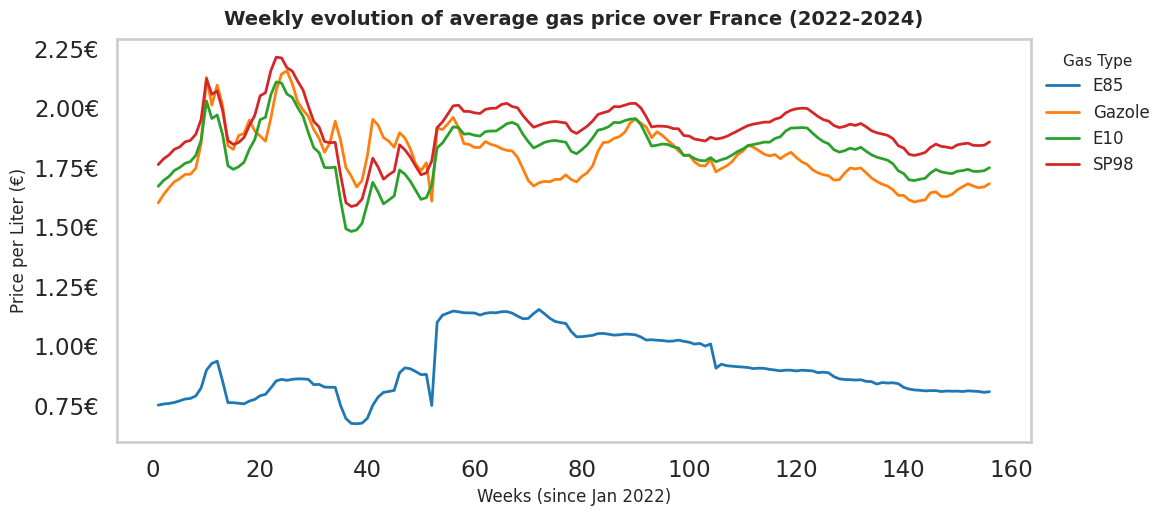

In [31]:
plt.figure(figsize=(12, 5.5))

ax = sns.lineplot(
    data=pdf_viz,
    x="week_index",
    y="avg_weekly_price",
    hue="name",
    palette=palette,
    linewidth=2
)

# 4. Final Formatting
plt.title("Weekly evolution of average gas price over France (2022-2024)", fontsize=14, fontweight='bold', pad=10)
plt.xlabel("Weeks (since Jan 2022)", fontsize=12)
plt.ylabel("Price per Liter (€)", fontsize=12)

# Format Currency
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f€'))

# Legend
plt.legend(title="Gas Type", bbox_to_anchor=[1, 1], loc='upper left', frameon=False, fontsize=12, title_fontsize=11)
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'average_gas.png'), dpi=300)
plt.show()

*Observation 1* : 
The significantly lower price of **E85** can be observed. In France, E85 benefits from a drastically reduced TICPE (domestic consumption tax on energy products) to encourage the transition to greener, agricultural based fuels. Additionally, because it is composed of up to 85% bioethanol (produced locally from sugar beets and corn) and only 15% gasoline, its price is largely decoupled from Brent crude oil fluctuations. 

It seems that this composition insulated E85 from the extreme geopolitical volatility of 2022, allowing it to remain the most competitive fuel option while fossil fuel prices surged.


* [Reference 1 ](https://essentica.eu/news/about-the-industry/french-drivers-increasingly-turn-to-cheaper-e85)
* [Reference 2 ](https://www.connexionfrance.com/news/french-motorists-rejecting-cheaper-green-fuel-despite-car-adaptions/408731)

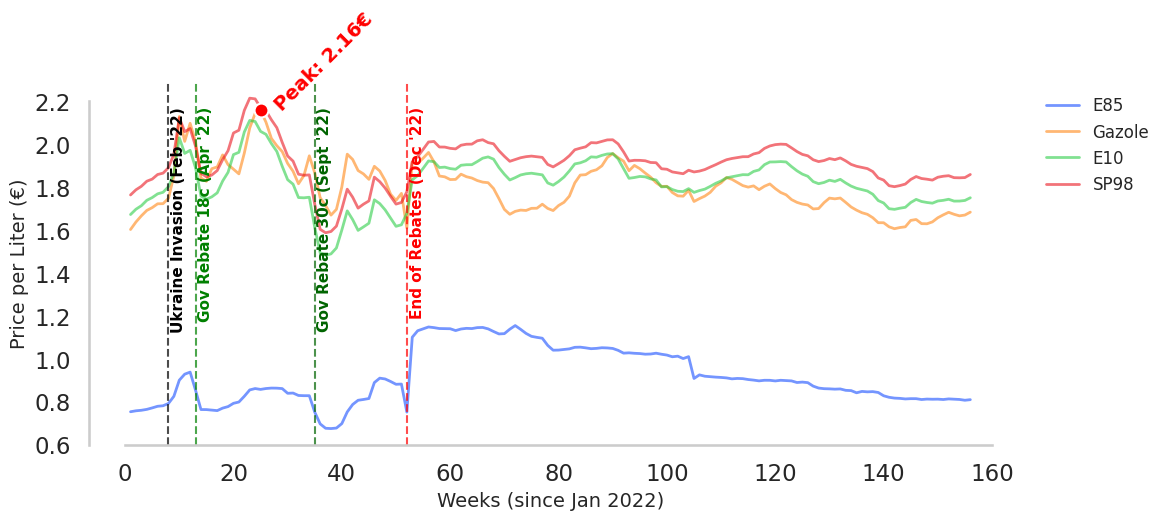

In [32]:
# Extra - Plot

plt.figure(figsize=(12, 5.5))

major_events = [
    {"week": 8,  "label": "Ukraine Invasion (Feb '22)", "color": "black"},
    {"week": 13, "label": "Gov Rebate 18c (Apr '22)",  "color": "green"},
    {"week": 35, "label": "Gov Rebate 30c (Sept '22)", "color": "darkgreen"},
    {"week": 52, "label": "End of Rebates (Dec '22)",      "color": "red"},
]

ax = sns.lineplot(
    data=pdf_viz,
    x="week_index",
    y="avg_weekly_price",
    hue="name",
    palette="bright",
    linewidth=2.0,
    alpha=0.55
)


for event in major_events:
    
    plt.axvline(x=event["week"], color=event["color"], linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Add Text Label (placed near the top of the chart)
    # We use axis coordinates (transform=ax.get_xaxis_transform()) for simpler placement
    plt.text(
        x=event["week"] + 0.5,     # Shift slightly right
        y=plt.ylim()[1] * 0.95,    # Place at 95% of max height
        s=event["label"], 
        rotation=90, 
        color=event["color"], 
        fontsize=11, 
        fontweight='bold',
        verticalalignment='top'
    )

# 3. Highlight the Absolute Peak (Optional)
# This usually happens right after the invasion (Week 10-11)
gazole_data = pdf_viz[pdf_viz['name'] == 'Gazole']
if not gazole_data.empty:
    max_idx = gazole_data['avg_weekly_price'].idxmax()
    max_row = gazole_data.loc[max_idx]
    plt.scatter(max_row['week_index'], max_row['avg_weekly_price'], s=100, color='red', zorder=10, edgecolors='white')
    plt.text(max_row['week_index'] + 2, max_row['avg_weekly_price'], 
             f"Peak: {max_row['avg_weekly_price']:.2f}€", color='red', fontweight='bold', rotation=45, fontsize=14)



plt.xlabel("Weeks (since Jan 2022)", fontsize=14)
plt.ylabel("Price per Liter (€)", fontsize=14)

#ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f€'))

# Legend
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, fontsize=12)
sns.despine(trim=True)

plt.tight_layout()
plt.grid(False)
plt.savefig(os.path.join(images_dir, 'average_gas_trends.png'), dpi=300)
plt.show()

*Observation 2* :  
This plot highlights the volatility of French fuel prices starting in early 2022, triggered by the **Russian invasion of Ukraine** (Week 8), which drove prices to historic highs (>2.00€ per unit). This inflationary trend was temporarily mitigated by **government funded rebates** introduced in April (18 cents) and increased in September (30 cents), clearly visible as sharp, artificial dips in the cost curve. Following the expiration of these subsidies in late 2022, prices stabilized at a new, higher baseline throughout 2023.

* [Reference 1 ](https://www.energierecrute.com/en/energy-environment-news/7531-diesel-prices-decrease-to-pre-war-levels-in-ukraine)
* [Reference 2 ](https://www.connexionfrance.com/news/recap-how-to-benefit-from-frances-18-cent-per-litre-fuel-discount/102453)


#### 4.2 Data Visualization – Bonus question

#### Departmental Map
The following code was adopted from [this notebook ](https://github.com/HerveMignot/geopython/blob/main/notebooks/Cartographie_avec_geopandas_%26_folium.ipynb)
The code has been modified to include all fuel types as toggleable layers on the map.

In [34]:
import folium
import requests
import json
from pyspark.sql.functions import col, substring, avg


gas_types = ["Gazole", "SP95", "SP98", "E10"]

# Load Geometry Once
dept_geo_url = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
geo_json_data = requests.get(dept_geo_url).json()

# Create Base Map
m_dept = folium.Map(location=[46.5, 2.3], zoom_start=6, tiles="cartodb positron")

for gas in gas_types:
    print(f"Processing layer: {gas}...")
    
    #Prepare Data
    pdf_gas = df_final.filter(col("name") == gas) \
        .withColumn("dept", substring(col("cp"), 1, 2)) \
        .groupBy("dept") \
        .agg(avg("price_index").alias("avg_index")) \
        .toPandas()
    
    # Create FeatureGroup (The Toggle Layer)
    # Only 'Gazole' is checked by default
    fg = folium.FeatureGroup(name=gas, show=(gas == "Gazole"))
    
    # Create Choroplet
    choropleth = folium.Choropleth(
        geo_data=geo_json_data,
        data=pdf_gas,
        columns=["dept", "avg_index"],
        key_on="feature.properties.code",
        fill_color="YlOrRd" if gas == "Gazole" else "BuPu",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=f"{gas} Price Index",
        nan_fill_color="white",
        width="50%",
        height="250px",
        highlight=True
    )
    
    # This ensures the map colors toggle on/off with the menu
    choropleth.geojson.add_to(fg)
    
    # Add the Legend (ColorScale) to the Map
    # Note: Folium legends do not toggle automatically. 
    # fix: We only show the legend for the default layer (Gazole).
    if gas == "Gazole":
        m_dept.add_child(choropleth.color_scale)
    
    # Add the FeatureGroup to the map
    fg.add_to(m_dept)

# Layer Control
folium.LayerControl(collapsed=False).add_to(m_dept)

title_html = '''
     <h3 align="center" style="font-size:16px"><b>Price Index by Department (Select Layer)</b></h3>
     '''
m_dept.get_root().html.add_child(folium.Element(title_html))

# Display the plot
m_dept.save(os.path.join(html_dir, 'map_depart.html'))
m_dept


Processing layer: Gazole...


Processing layer: SP95...


Processing layer: SP98...


Processing layer: E10...


#### Communal Map
The following code was adopted from [this notebook ](https://github.com/HerveMignot/geopython/blob/main/notebooks/Cartographie_avec_geopandas_%26_folium.ipynb)
The code has been modified to include all fuel types as toggleable layers on the map.

In [ ]:
from folium.plugins import HeatMap
import folium
from pyspark.sql.functions import col, avg


m_local = folium.Map(location=[46.5, 2.3], zoom_start=6, tiles="cartodb dark_matter")
gas_types = ["Gazole", "SP95", "SP98", "E10"]

# loop through Gas Types to create layers
for gas in gas_types:
    print(f"Processing HeatMap layer: {gas}...")

    # Prepare Data (Spark -> Pandas)
    # We filter specifically for the current gas type in the loop
    df_local_viz = df_final.filter(col("name") == gas) \
        .groupBy("lat", "long") \
        .agg(avg("price_index").alias("avg_index")) \
        .toPandas()
    
    # Prepare the Data
    # We filter out data < 90 to keep the map clean (only showing above-average-ish areas)
    heat_data = [
        [row['lat'], row['long'], (row['avg_index'] - 90)] 
        for index, row in df_local_viz.iterrows() 
        if row['avg_index'] > 90  # Changed to > 90 to avoid negative weights
    ]
    
    # Create Feature Group (The Layer)
    # Only show 'Gazole' by default to avoid clutter
    fg = folium.FeatureGroup(name=gas, show=(gas == "Gazole"))
    
    # Add HeatMap
    HeatMap(
        heat_data,
        radius=15,
        blur=20,
        max_zoom=10,
        gradient={0.4: 'cyan', 0.65: 'lime', 1: 'red'}
    ).add_to(fg)
    

    fg.add_to(m_local)

# Add Layer Control (The Dropdown)
folium.LayerControl(collapsed=False).add_to(m_local)


title_html = '''
     <h3 align="center" style="color: white; font-size:16px"><b>Gas Price Intensity (Select Layer)</b></h3>
     '''
m_local.get_root().html.add_child(folium.Element(title_html))

m_local.save(os.path.join(html_dir, 'map_local.html'))
m_local

## 5. Modeling – Forecast next day price

### 5.1 Data Preperation

This section implement a machine learning pipeline using **Spark ML** to predict the next day's gas price for a given station. Following the [https://arxiv.org/abs/2101.02118](https://arxiv.org/abs/2101.02118) in *"Do We Really Need Deep Learning Models for Time Series Forecasting?"*, we move away from traditional time series models (like ARIMA) in favor of a **window-based regression approach**. The **lag variables** (e.g., prices from , ) were used to capture temporal dependencies by transforming the forecasting task into a standard supervised regression problem. This techniques helps to implement algorithms like **Linear Regression**, **Random Forest**, and **Gradient-Boosted Trees (GBRT)** to efficiently predict future prices within the distributed Spark framework.

In [ ]:
# Setup: Spark ML, Window functions (for lag features), and Evaluation metrics
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, avg, dayofweek, month
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

In [ ]:
# Filter dataset to focus on a single gas type ("Gazole") for modeling
target_gas = "Gazole" 
df_ml = df_final.filter(col("name") == target_gas)
df_ml.select("id", "name", "day_date").show(5)


# Sanity check: Identify potential price outliers 
#df_ml = df_ml.filter(col("name") == "Gazole") \
#                .filter(col("prix") < 5.0).show(100) 

To use standard regression algorithms (like Random Forest) for forecasting, we must transform the time series data into a supervised learning format. As detailed in the [https://arxiv.org/abs/2101.02118](https://arxiv.org/abs/2101.02118) we created **Lag Features** to capture temporal dependencies.

* **`price_lag_1`**: The price from the previous day (Autoregression).
* **`price_lag_7`**: The price from last week (Weekly Seasonality).
* **`rolling_avg_7`**: A moving average to capture the general trend and reduce noise.

The `VectorAssembler` is used to combine these inputs into a single vector column (mandatory format for Spark ML algorithms).

In [ ]:
# Define Window: Partition by station/gas type to prevent data leaking between stations
window_spec = Window.partitionBy("id", "name").orderBy("day_date")

# Create Lag & Rolling Features (Transform Time Series -> Regression)
df_features = df_ml \
    .withColumn("price_lag_1", lag("prix", 1).over(window_spec)) \
    .withColumn("price_lag_7", lag("prix", 7).over(window_spec)) \
    .withColumn("rolling_avg_7", avg("prix").over(window_spec.rowsBetween(-7, -1))) \
    .withColumn("day_of_week", dayofweek("day_date")) \
    .withColumn("month", month("day_date")) \
    .dropna()  # Drop rows with nulls (first 7 days of history)

# Consolidate all input features into a single 'features' vector for Spark ML
feature_cols = ["price_lag_1", "price_lag_7", "rolling_avg_7", "day_of_week", "month", "lat", "long"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_model_ready = assembler.transform(df_features)

df_model_ready.select("id", "day_date", "prix", "features").show(5, truncate=False)

We selected specific features to capture diverse temporal patterns. While **`price_lag_1`** captures immediate continuity (yesterday's price), **`price_lag_7`** is critical for detecting **weekly seasonality** (e.g., price changes specific to weekends), which consecutive lags like `t-2` or `t-3` would miss. Additionally, **`rolling_avg_7`** provides a smoothed baseline of the week's trend, allowing the model to distinguish between a one-off outlier and a genuine market shift.

In [ ]:
df_model_ready.select("id", "prix", "price_lag_1", "price_lag_7", "rolling_avg_7", "day_of_week", "month", "lat", "long").show(5)

### 5.2 Train-Test Split (Time Series Data) 

Because we are dealing with Time Series data, we cannot use a standard random split (like randomSplit([0.8, 0.2])). Random shuffling would allow the model to "peek" into the future (e.g., using data from tomorrow to predict today), which causes data leakage and unrealistic accuracy. Instead, we must perform a strictly chronological split: (we train on the past and test on the future).

To adhere to a strict 80% Training / 20% Testing split without shuffling (which would break the time series), we calculate the 80th percentile of the dates. 

In [ ]:
from pyspark.sql.functions import to_timestamp
from datetime import datetime

# Convert Date to Numeric (Timestamp Long) for Quantile Calculation
df_timed = df_model_ready.withColumn("unix_time", col("day_date").cast("timestamp").cast("long"))

# Find the 80% mark
# approxQuantile(col, probabilities, relativeError)
split_timestamp = df_timed.stat.approxQuantile("unix_time", [0.8], 0.001)[0]

# Convert back to string for filtering and display
split_date = datetime.fromtimestamp(split_timestamp).strftime('%Y-%m-%d')



# Perform the Chronological Split
train_data = df_model_ready.filter(col("day_date") < split_date)
test_data = df_model_ready.filter(col("day_date") >= split_date)

# Verify the Split Ratio
total_count = df_model_ready.count()
train_count = train_data.count()
test_count = test_data.count()

print(f"Training Samples: {train_count:,} ({train_count/total_count:.1%})")
print(f"Testing Samples:  {test_count:,} ({test_count/total_count:.1%})")

### 5.3 Model Training & Prediction

We train three distinct models to compare performance:

1. **Linear Regression**: A simple baseline model to establish a reference point.
2. **Random Forest**: A bagging ensemble method that handles non linearities well.
3. **Gradient Boosted Trees (GBT)**: The specific model highlighted in the [https://arxiv.org/abs/2101.02118](https://arxiv.org/abs/2101.02118).


In [ ]:
# ==========================================
# Model Training (Linear Regression, Random Forest, GBT)
# ==========================================

# --- Model 1: Linear Regression (Baseline) ---
print("Training Linear Regression...")
lr = LinearRegression(featuresCol="features", labelCol="prix")
lr_model = lr.fit(train_data)
pred_lr = lr_model.transform(test_data)

# --- Model 2: Random Forest (Non-linear interactions) ---
print("Training Random Forest...")
rf = RandomForestRegressor(featuresCol="features", labelCol="prix", numTrees=30, maxDepth=10)
rf_model = rf.fit(train_data)
pred_rf = rf_model.transform(test_data)

# --- Model 3: Gradient Boosted Trees (https://arxiv.org/abs/2101.02118 Recommendation) ---
print("Training GBT Regressor...")
gbt = GBTRegressor(featuresCol="features", labelCol="prix", maxIter=20)
gbt_model = gbt.fit(train_data) 
pred_gbt = gbt_model.transform(test_data)

To assess the performance of our models

* **RMSE (Root Mean Squared Error)**: Penalizes larger errors more heavily (useful for detecting outliers).
* **MAE (Mean Absolute Error)**: The average error in the same unit as the price.
* **(R-Squared)**: Indicates how much of the variance in the price is explained by our model (closer to 1 is better).

In [ ]:
evaluator_rmse = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="r2")

In [ ]:
def get_metrics(predictions, model_name):
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    
    return {
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }

# Collect results into a list
results_list = [
    get_metrics(pred_lr, "Linear Regression"),
    get_metrics(pred_rf, "Random Forest"),
    get_metrics(pred_gbt, "GBT Regressor")
]


metrics_df = pd.DataFrame(results_list)
metrics_df.set_index("Model", inplace=True)
print("Model Performance Comparison:")
metrics_df

### 5.4 Dispersion Plots (Actual vs. Predicted)

These scatter plots show the relationship between the **Actual Price (-axis)** and the **Predicted Price (-axis)**.


In [ ]:
# Sample Data (5%) to make plotting faster and clearer (increase as you want!! ;))
# Same seed to compare roughly the same subset of days
sample_lr = pred_lr.select("prix", "prediction").sample(fraction=0.05, seed=42).toPandas()
sample_rf = pred_rf.select("prix", "prediction").sample(fraction=0.05, seed=42).toPandas()
sample_gbt = pred_gbt.select("prix", "prediction").sample(fraction=0.05, seed=42).toPandas()

# Set Global Axis Limits
all_mins = [sample_lr.min().min(), sample_rf.min().min(), sample_gbt.min().min()]
all_maxs = [sample_lr.max().max(), sample_rf.max().max(), sample_gbt.max().max()]
global_min = min(all_mins)
global_max = max(all_maxs)


fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

# Helper function
def plot_dispersion(ax, data, title, color):
    sns.scatterplot(x=data["prix"], y=data["prediction"], alpha=0.6, color=color, ax=ax)
    ax.plot([global_min, global_max], [global_min, global_max], 'r--', lw=2, label="Perfect Prediction") #"Perfect Prediction is the diagonal line
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Actual Price (€)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

# Plot1 Linear Regression 
plot_dispersion(axes[0], sample_lr, "Linear Regression", "tab:blue")
axes[0].set_ylabel("Predicted Price (€)", fontsize=12) # Only Y-label on the first plot

# Plot2: Random Forest 
plot_dispersion(axes[1], sample_rf, "Random Forest", "tab:green")

# Plot 3: GBT Regressor 
plot_dispersion(axes[2], sample_gbt, "GBT Regressor", "tab:orange")


plt.suptitle(f"Model Comparison: {target_gas} Price Prediction", fontsize=14)
plt.tight_layout()
plt.show()

* **The Ideal Scenario**: All points would fall exactly on the red diagonal dashed line (), representing zero error.
* **The Reality**: The "cloud" of points shows the variance. A tighter cloud around the red line indicates a better model.
* **Visual Comparison**: We plot **Linear Regression**, **Random Forest**, and **GBT** side-by-side. We generally expect the tree-based models (RF and GBT) to hug the diagonal line closer than Linear Regression, especially for extreme price values.


In [ ]:
# Extra
# ==========================================
# Time Series Inspection (All Models)
# ==========================================

# Pick a one station to visualize
from pyspark.sql.functions import rand
station_id = test_data.select("id").orderBy(rand()).first()[0] 
print(f"Visualizing Forecast for Station ID: {station_id}")

# 2. Extract Data for this Station from ALL 3 Models
# We convert to Pandas since the data for one station is small and easy to plot
pdf_lr = pred_lr.filter(col("id") == station_id).select("day_date", "prediction").orderBy("day_date").toPandas()
pdf_rf = pred_rf.filter(col("id") == station_id).select("day_date", "prediction").orderBy("day_date").toPandas()
pdf_gbt = pred_gbt.filter(col("id") == station_id).select("day_date", "prediction", "prix").orderBy("day_date").toPandas()

# 3. Plotting
plt.figure(figsize=(12, 5.5))

# A. Plot Actual Price (Ground Truth)
sns.lineplot(x=pdf_gbt["day_date"], y=pdf_gbt["prix"], label="Actual Price", color="black", linewidth=2, zorder=10)

# B. Plot Model Predictions
sns.lineplot(x=pdf_lr["day_date"], y=pdf_lr["prediction"], label="Linear Regression", color="tab:blue", linestyle="--", linewidth=1.5)
sns.lineplot(x=pdf_rf["day_date"], y=pdf_rf["prediction"], label="Random Forest", color="tab:green", linestyle="-.", linewidth=1.5)
sns.lineplot(x=pdf_gbt["day_date"], y=pdf_gbt["prediction"], label="GBT Regressor", color="tab:orange", linestyle=":", linewidth=2)

# C. Formatting
plt.title(f"Forecast Validation for Station {station_id}: All Models", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (€)", fontsize=12)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True, alpha=0.1)

# Format Date axis nicely (Year-Month)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### EXTRA : Pipeline and deployment



In [ ]:
# List of variables to clean up
vars_to_clean = ['train_data', 'test_data', 'df_features', 'df_model_ready', 'lr_model', 'rf_model', 'gbt_model']

print("Cleaning up previous variables...")

for var in vars_to_clean:
    if var in globals():
        # 1. If it's a Spark DataFrame, unpersist it to free up RAM
        try:
            if hasattr(globals()[var], "unpersist"):
                globals()[var].unpersist()
        except:
            pass
        
        # 2. Delete the Python variable
        del globals()[var]

print("Environment clean. Ready to rebuild Section 5.")

In [ ]:
# --- 1. Re-Create Features ---
# Define Window
window_spec = Window.partitionBy("id", "name").orderBy("day_date")

# Create Lag & Rolling Features
df_features = df_ml \
    .withColumn("price_lag_1", lag("prix", 1).over(window_spec)) \
    .withColumn("price_lag_7", lag("prix", 7).over(window_spec)) \
    .withColumn("rolling_avg_7", avg("prix").over(window_spec.rowsBetween(-7, -1))) \
    .withColumn("day_of_week", dayofweek("day_date")) \
    .withColumn("month", month("day_date")) \
    .dropna() 

# Assemble Vectors
feature_cols = ["price_lag_1", "price_lag_7", "rolling_avg_7", "day_of_week", "month", "lat", "long"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_model_ready = assembler.transform(df_features)

# --- 2. Re-Split Data (Chronological) ---
# Dynamic 80/20 split
split_timestamp = df_model_ready.withColumn("u", col("day_date").cast("timestamp").cast("long")) \
                                .stat.approxQuantile("u", [0.8], 0.001)[0]
split_date = pd.to_datetime(split_timestamp, unit='s').strftime('%Y-%m-%d')

print(f"New Split Date: {split_date}")

train_data = df_model_ready.filter(col("day_date") < split_date)
test_data = df_model_ready.filter(col("day_date") >= split_date)

print(f"Fresh Training Samples: {train_data.count():,}")
print(f"Fresh Testing Samples:  {test_data.count():,}")

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

def run_ml_pipeline(model_algorithm, model_name, train_df, test_df):
    """
    Creates a pipeline, trains it, and evaluates the results.
    Standardizes the feature assembly process to ensure no data leakage.
    """
    print(f"\nRunning Pipeline for: {model_name}...")
    
    # --- STAGE 1: Feature Assembly ---
    # Define input columns (Lag features + Date info + Location)
    feature_cols = ["price_lag_1", "price_lag_7", "rolling_avg_7", "day_of_week", "month", "lat", "long"]
    
    # Transform individual columns into a single 'features' vector
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    
    # --- STAGE 2: Build Pipeline ---
    # Combine the assembler (preprocessing) and the model (algorithm)
    pipeline = Pipeline(stages=[assembler, model_algorithm])
    
    # --- STAGE 3: Train & Predict ---
    model_fit = pipeline.fit(train_df)
    predictions = model_fit.transform(test_df)
    
    # --- STAGE 4: Evaluate ---
    evaluator_rmse = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="r2")
    
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    
    print(f"--- {model_name} Results ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f} €")
    print(f"R2:   {r2:.4f}")
    
    # Return model and predictions for visualization
    return model_fit, predictions

# ==========================================
# 3. Execution (Run All Models)
# ==========================================

# A. Linear Regression (Baseline)
lr = LinearRegression(labelCol="prix")
lr_pipeline_model, lr_preds = run_ml_pipeline(lr, "Linear Regression", train_data, test_data)

# B. Random Forest (Non-linear)
rf = RandomForestRegressor(labelCol="prix", numTrees=30, maxDepth=10)
rf_pipeline_model, rf_preds = run_ml_pipeline(rf, "Random Forest", train_data, test_data)

# C. Gradient Boosted Tree (Paper Recommendation)
gbt = GBTRegressor(labelCol="prix", maxIter=20)
gbt_pipeline_model, gbt_preds = run_ml_pipeline(gbt, "GBT Regressor", train_data, test_data)